# Unsupervised learning: Clustering

$\textit{Authors:}$ Nikolaj Krebs \& Simon Guldager \
$\textit{Date:}$ 11-09-2024

... there are many models to choose from when doing cluster analysis (see https://scikit-learn.org/stable/modules/clustering.html), each with its own strength and weakness. In this excercise, we'll have a go at Kmeans and DBSCAN clustering

In [1]:
import os
import warnings
# Data handling and manipulation library
import pandas as pd
# Data visualization library based on matplotlib
import seaborn as sns
# Basic plotting library in Python
import matplotlib.pyplot as plt
from matplotlib import cm

# Library for numerical operations in Python
import numpy as np
# Preprocessing tool to standardize features (mean=0, variance=1)
from sklearn.preprocessing import StandardScaler

# Visualization tool for the elbow method to determine the optimal number of clusters
from yellowbrick.cluster.elbow import kelbow_visualizer

# Calculates the Silhouette Score which measures the quality of clusters
from sklearn.metrics import silhouette_score
# KMeans clustering algorithm
from sklearn.cluster import KMeans, DBSCAN
# Splits data into random train and test subsets
from sklearn.model_selection import train_test_split
# Generates a confusion matrix
from sklearn.metrics import silhouette_score


## some stuff for making pretty plots
from matplotlib import rcParams
from cycler import cycler
## Set plotting style and print options
sns.set_theme()
sns.set_style("whitegrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster
# Set figure format
wide_format, square_format = False, True
if wide_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 18, 'axes.labelsize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12,\
     'legend.fontsize': 15, 'font.family': 'serif', 'figure.figsize': (9,6)}
if square_format:
    d = {'lines.linewidth': 2, 'axes.titlesize': 16, 'axes.labelsize': 14, 'xtick.labelsize': 10, 'ytick.labelsize': 10,\
     'legend.fontsize': 12, 'font.family': 'serif', 'figure.figsize': (6,6)}
    
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)

### Data preparation \& Preprocessing

#### Loading the data
...we will work on health descriptives dataset for this exercise.


In [2]:
# set the relative directory of the health data csv
data_dir = 'data_processed'
df = pd.read_csv(os.path.join(data_dir, 'health_data_cleaned.csv'))
df = df.apply(lambda x: x.replace(',', '.', regex=True))

# set the string column(s)
str_cols = ['brick']
# extract numerical columns
num_cols = list(df.columns.difference(str_cols))

# convert num_cols column(s) to numerical
df[num_cols] = df[num_cols].astype(float)

# choose which columns to drop
drop_cols = ['brick', 'brick_nr']
df_num = df.drop(drop_cols, axis=1)
df_num.head(3)

,blood clot in heart,absence,life_expectancy_years,longterm_disease_andel,overweight_andel,t2d_patients,uddannelse_lang_amount,physical_activity
0,0.0205,6.286500,77.190500,0.406500,0.175500,2248.978472,6035.258672,0.302000
1,0.0090,5.747333,79.967667,0.326667,0.130333,6136.772115,64810.874712,0.243333
2,0.0075,5.499500,79.283000,0.305000,0.107500,3019.148357,44280.909321,0.221500


#### Apply feature scaling to the independent variables

 We do this to center the data around zero and constrain the variation along basis dimension to obtain similarity.

In [3]:
# Initialize the StandardScaler object
# StandardScaler standardizes the dataset by setting the mean to 0 and variance to 1
scaler = StandardScaler()

# Fit and transform the DataFrame using StandardScaler
# The output will be a NumPy array of scaled features
df_scaled_full = scaler.fit_transform(df_num)

# Convert the NumPy array back to a DataFrame and use original column names
# Now df_scaled contains the scaled features of the original DataFrame
df_scaled_full = pd.DataFrame(df_scaled_full, columns=df_num.columns)
df_scaled_full.head()

,blood clot in heart,absence,life_expectancy_years,longterm_disease_andel,overweight_andel,t2d_patients,uddannelse_lang_amount,physical_activity
0,2.557987,1.603734,-3.903548,1.695694,-0.044889,-1.330851,-1.110746,0.127672
1,-1.287958,-0.243674,-0.817959,-1.275496,-1.244093,1.610886,2.764029,-1.512742
2,-1.789603,-1.092853,-1.578662,-2.081873,-1.850333,-0.748094,1.410593,-2.123237
3,-1.622388,-0.817027,-0.726482,-1.988829,-2.049463,-0.469300,1.758183,-2.025371
4,-1.622388,-0.962649,-1.175904,-2.044655,-1.943260,-0.327556,1.936749,-2.081294


# Clustering

### K-means clustering

**Why do you cluster**:
Clustering is a method of unsupervised learning, meaning it **allows for ignorance of true labels**. There are many different algorithms for clustering data but today we will show how to apply `kMeans`. 
Cluster analysis works to perform taxanomy description. This means that you find natural groups within the data not based on the variables, but based on the characteristica the data units share

**How K-Means clustering works**:
- You select the number of clusters that you want to identify in your data. This is the K in K-Means clustering
- The centroid seeds for each cluster is randomly created based on random datapoints from the data. If you choose to create 3 clusters (K=3), 3 random centroid seeds will initially be created
- The distance is measured between the first datapoint and the three initial clusters. 
- The first datapoint is assigned to the nearest cluster
- Now we do the same thing for the next datapoint and continue this process until we have assigned all datapoints
- Then the mean of each cluster is calculated
- Then we measure and cluster again, but this time using the mean values as the centroid seeds
- The quality of the clusters are assessed by adding up the variation within each cluster. 
- KMeans keep track of the total variance within each cluster. 
- Then KMeans creates 3 new random centroid seeds based on random datapoints from the data. Calculate the mean of each cluster, reclusters based on the new mean etc.
- KMeans does this as many times as you tell it to. 

- **A video explaining K-means clustering:** https://www.youtube.com/watch?v=4b5d3muPQmA


... choose features to cluster

In [4]:
features = ['physical_activity','longterm_disease_andel','life_expectancy_years',]
Nfeatures = len(features)
df_scaled = df_scaled_full[features]
df_scaled.head(3)

,physical_activity,longterm_disease_andel,life_expectancy_years
0,0.127672,1.695694,-3.903548
1,-1.512742,-1.275496,-0.817959
2,-2.123237,-2.081873,-1.578662


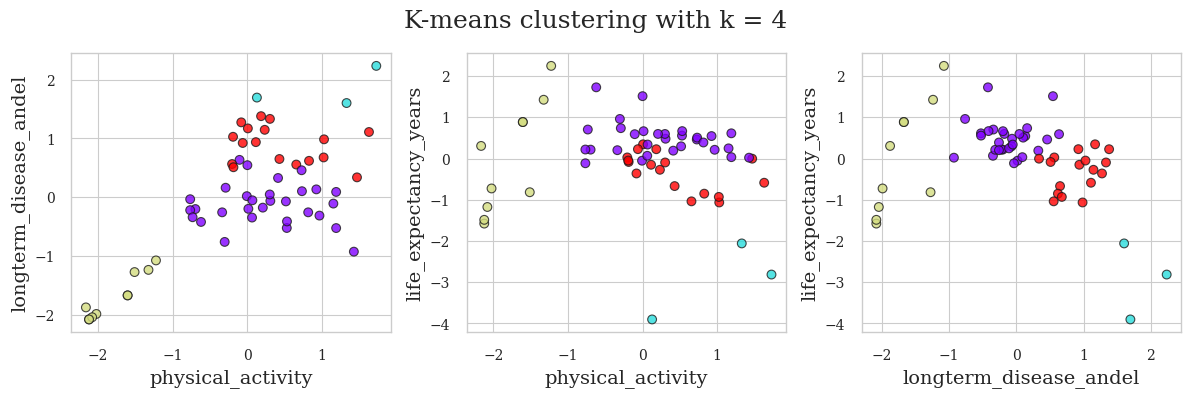

In [6]:
# Set number of clusters
nclusters = 4

# Initialize K-means algorithm with 4 clusters
# This initializes a KMeans object that will segment the data into 17 clusters
kmeans = KMeans(n_clusters=nclusters, n_init = 5,)

# Fit the K-means algorithm to the scaled data
# The fit method computes centroids of 4 clusters in the scaled feature space

with warnings.catch_warnings(): # ignore warnings
    warnings.simplefilter("ignore", category=UserWarning)
    kmeans.fit(df_scaled)

# Retrieve the cluster labels
# After fitting, each instance in df_scaled is assigned to one of the 17 clusters
labels = kmeans.labels_

# Shift labels
shifted_labels = labels + 1

# Create a 2D scatter plots to visualize the clustering
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
fig.suptitle(f"K-means clustering with k = {nclusters}", fontsize=18)

ax[0].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)
ax[1].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 2], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)
ax[2].scatter(df_scaled.iloc[:, 1], df_scaled.iloc[:, 2], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)

ax[0].set(xlabel = features[0], ylabel = features[1])
ax[1].set(xlabel = features[0], ylabel = features[2])
ax[2].set(xlabel = features[1], ylabel = features[2])
fig.tight_layout();

Let's visualize the clustering in 3D

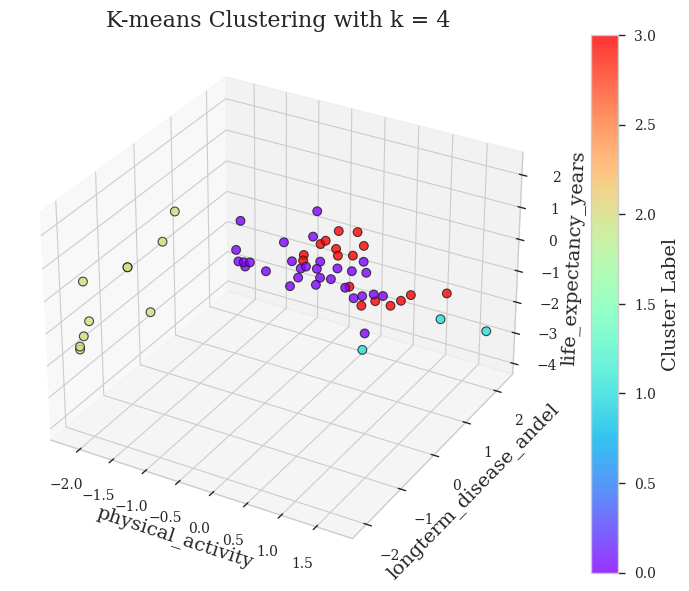

In [7]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using first three features for the x, y, and z-axis
sc = ax.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], df_scaled.iloc[:, 2], 
                c=labels, cmap='rainbow', edgecolor='k', s=40, alpha=0.8)

# Add titles and labels
plt.title(f"K-means Clustering with k = {nclusters}")
ax.set_xlabel(features[0])
ax.set_ylabel(features[1])
ax.set_zlabel(features[2])

# Add a color bar
plt.colorbar(sc, label='Cluster Label')
plt.tight_layout();

### How do we find the optimal number of clusters?

There are several methods to estimate this, and we will use:
- Elbow method: mean sum of squared distances to centers (elbow method)
- Silhouette score: mean ratio of intra-cluster and nearest-cluster distance
- Calinski_harabasz: ratio of within to between cluster dispersion

Elbow method: By calculating the 'distortion', i.e. the sum of squared distances of each point to its assigned center, using different number of clusters, the elbow/knee of the graph, i.e. where the slope changes quickly, can be taken as the optimal number of clusters

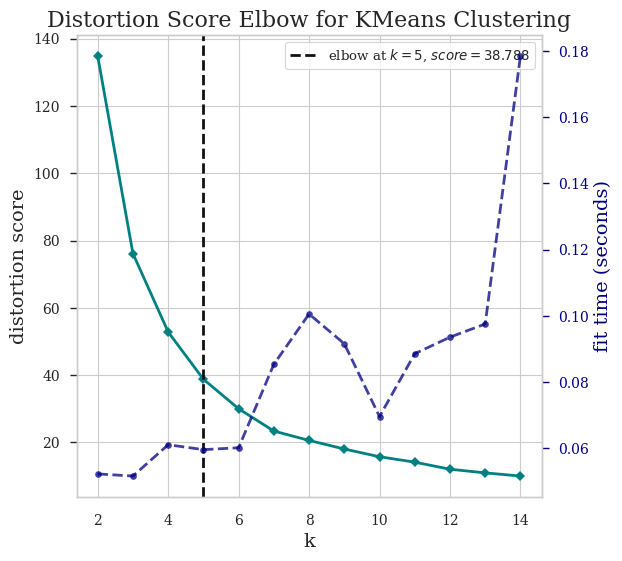

In [24]:
## Using the ElbowVisualizer to detect the optimal number of clusters for our KMeans implementation
## Documentation: https://www.scikit-yb.org/en/latest/api/cluster/elbow.html

# ignore warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # Use the quick method and immediately show the figure (k is the number of clusters)
    kelbow_visualizer(KMeans(random_state=42, n_init=25), df_scaled, metric='distortion', k=(2,15))


Similarly, we can calculate the silhouette and calinski_harabasz scores by changing the metric. With silhouette, we are looking for the 1st peak, and with calinski_harabasz, we are again looking for an 'elbow'

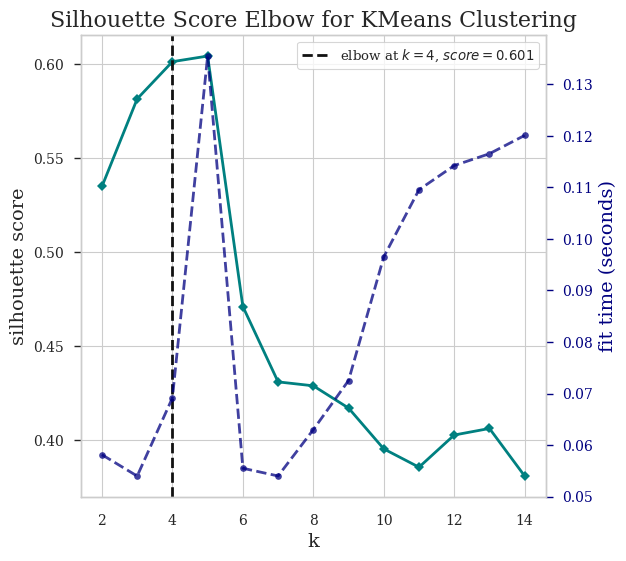

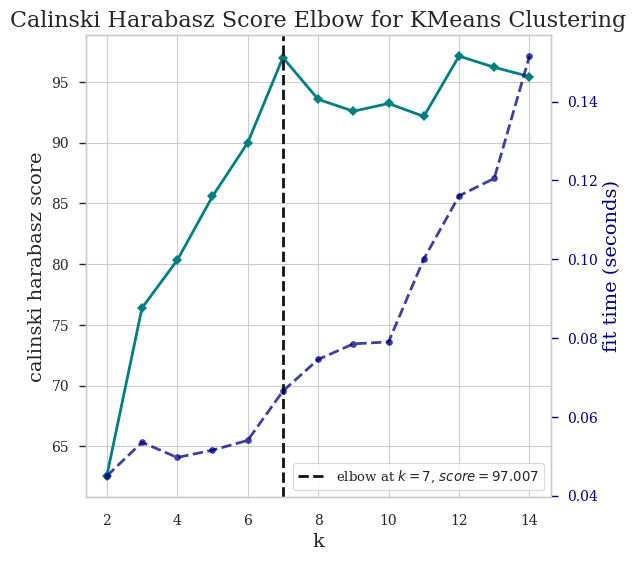

In [25]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=UserWarning)
    # Use the quick method and immediately show the figure (k is the number of clusters)
    kelbow_visualizer(KMeans(random_state=42,n_init=25), df_scaled, metric='silhouette', k=(2,15))
    kelbow_visualizer(KMeans(random_state=42,n_init=25), df_scaled, metric='calinski_harabasz', k=(2,15))

### Clustering: DBSCAN

Density Based Spatial Clustering of Applications with Noise (abbreviated as DBSCAN) is a density-based unsupervised clustering algorithm. In DBSCAN, clusters are formed from dense regions and separated by regions of no or low densities.

DBSCAN computes nearest neighbor graphs and creates arbitrary-shaped clusters in datasets (which may contain noise or outliers) as opposed to k-means clustering, which typically generates spherical-shaped clusters
Unlike k-means clustering, DBSCAN does not require specifying the number of clusters initially. However, DBSCAN requires two parameters viz. the radius of neighborhoods for a given data point p (eps or ε) and the minimum number of data points in a given ε-neighborhood to form clusters (min_samples).

min_samples should be chosen at least as big as twice the number of features, whereas eps must be found by hyperoptimization, which we will do below

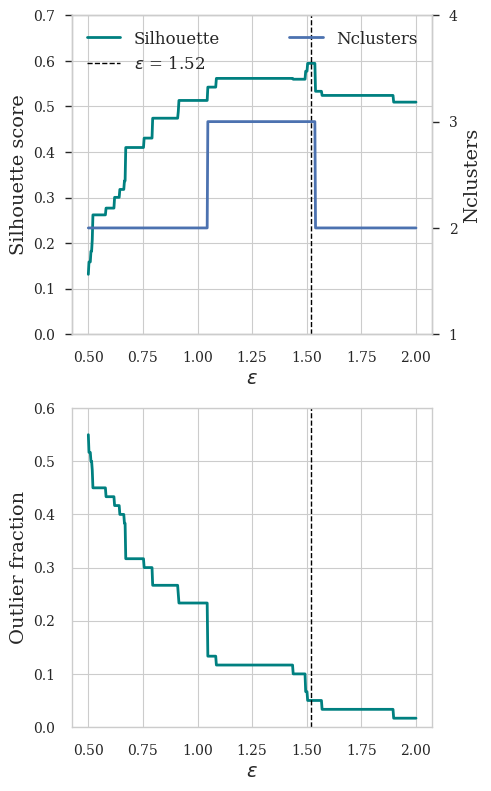

In [37]:
# choose epsilon values 
eps_min_value = 0.5
eps_max_value = 2
eps_number_of_values = 500
eps_list = np.linspace(eps_min_value, eps_max_value, eps_number_of_values)

# make empty arrays to store silhouette scores, the estimated number of clusters, 
# and the share of points that are outliers, i.e. belong to no cluster
silhouette_list = np.empty_like(eps_list)
ncluster_list = np.empty_like(eps_list)
outlier_list = np.empty_like(eps_list)

for i, eps in enumerate(eps_list):
    # instantiate regressor and fit
    db = DBSCAN(eps = eps, min_samples = 2 * Nfeatures, leaf_size = 2).fit(df_scaled)
    labels = db.labels_

    # store silhouette score
    silhouette_list[i] = silhouette_score(df_scaled,labels)
    # find number of clusters as the number of unique labels
    # ... (-1, since outliers have label = -1)
    ncluster_list[i] = len(np.unique(labels)) - 1
    # find fraction of outliers (which have label = -1) by counting these
    # and dividing by the total number of points
    outlier_list[i] = (labels == -1).sum() / len(labels)

# Let's plot the results
fig, ax = plt.subplots(nrows=2, figsize=(5,8))
eps_best = 1.52

ax[0].plot(eps_list, silhouette_list, label = 'Silhouette')
ax[0].vlines(eps_best, 0, 4, ls='--', color='black', lw=1, label = fr'$\epsilon$ = {eps_best}')
ax[0].set(xlabel = r'$\epsilon$', ylabel = r'Silhouette score', ylim = [0,0.7])
ax[0].legend(loc='upper left')

# create another y-axis for plotting Nclusters
axx = ax[0].twinx()
axx.plot(eps_list,ncluster_list, 'b-', label = 'Nclusters')
axx.grid(False)
axx.set(ylabel = 'Nclusters', yticks=[1,2,3,4], yticklabels=[1,2,3,4])
axx.legend(loc = 'upper right')


ax[1].plot(eps_list, outlier_list)
ax[1].vlines(eps_best, 0, 4, ls='--', color='black', lw=1, label = fr'$\epsilon$ = {eps_best}')
ax[1].set(xlabel=r'$\epsilon$', ylabel = 'Outlier fraction', ylim = [0,.6])
fig.tight_layout()

Let's do the clustering using eps = 1.52

Number of clusters:  3
Number of points:  60
Number of outliers:  3


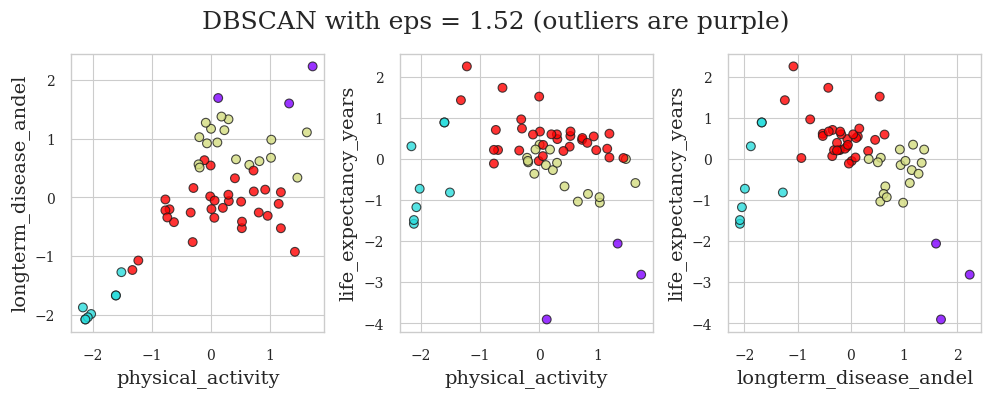

In [38]:
# Set number of clusters
eps = 1.52

# initialize and fit
db = DBSCAN(eps = eps, min_samples = 2 * Nfeatures, leaf_size = 2).fit(df_scaled)
labels = db.labels_

print("Number of clusters: ", len(np.unique(labels)) - 1)
print("Number of points: ", len(labels))
print("Number of outliers: ", (labels == -1).sum())

# Create a 2D scatter plots to visualize the clustering
fig, ax = plt.subplots(ncols=3, figsize=(10, 4))
fig.suptitle(f"DBSCAN with eps = {eps} (outliers are purple)", fontsize=18)

ax[0].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)
ax[1].scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 2], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)
ax[2].scatter(df_scaled.iloc[:, 1], df_scaled.iloc[:, 2], cmap = 'rainbow', c=labels, edgecolor='k', s=40, alpha=0.8)

ax[0].set(xlabel = features[0], ylabel = features[1])
ax[1].set(xlabel = features[0], ylabel = features[2])
ax[2].set(xlabel = features[1], ylabel = features[2])
fig.tight_layout();

## Clustering Exercises

### Exercise 1
Choose 3 features and perferm K-means clustering on them. Find the optimal number of clustering by
* Visual inspection - do the clusters look well-separated?
* Calculating the Elbow, Silhouette and Calinski-Harabasz score

... having found the optimal number of clusters, visualize your results in 2D and 3D

### Exercise 2 
1. Using the same features as you used in exercise 1, perform clustering using DBSCAN and find the optimal eps by hyperoptimization as shown above, i.e. look at the silhouette score, the number of clusters and fraction of outliers for different values of eps, and choose what you deem the best one.
2. Having found the optimal eps, perform DBSCAN clustering and visualize the results


### Exercise 3
Pick your favorite clustering algorithm (see https://scikit-learn.org/stable/modules/clustering.html) and redo the cluster analysis. Can you improve the results as compared to those of K-means and DBSCAN?
